In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
from itertools import product
import numpy as np

In [2]:
from min_bisection import solution_schema

In [97]:
# fldr = 'runs\\warm_start'
fldr = 'runs\\fixed'

In [98]:
dfs = []
sub_fldrs = [x[0] for x in os.walk(fldr)]
for sub_fldr in sub_fldrs[1:]:
    print(sub_fldr)
    dfs.append(pd.read_csv(os.path.join(sub_fldr, 'summary_stats.csv')))
meta = pd.concat(dfs)

runs\fixed\fixed_10
runs\fixed\fixed_20
runs\fixed\fixed_30
runs\fixed\fixed_40
runs\fixed\fixed_50
runs\fixed\fixed_60


In [99]:
meta

,solve_id,solve_type,method,warm_start,n,p,q,cut_type,cut_value,max_variables,max_constraints,total_cpu_time,gurobi_cpu_time,non_gurobi_cpu_time,objective_value
0,0,once,dual,cold,10,0.5,0.1,fixed,10,45,481,0.039328,0.006504,0.032824,1.0
1,0,iterative,dual,warm,10,0.5,0.1,fixed,10,45,141,0.051323,0.007964,0.043359,1.0
2,0,iterative,dual,cold,10,0.5,0.1,fixed,10,45,151,0.054123,0.005255,0.048868,1.0
3,0,once,auto,cold,10,0.5,0.1,fixed,10,45,481,0.036401,0.005849,0.030551,1.0
4,0,iterative,auto,warm,10,0.5,0.1,fixed,10,45,141,0.051576,0.008919,0.042656,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,3,iterative,dual,warm,60,0.5,0.1,fixed,300,1770,103666,40226.266100,39685.561603,540.704497,84.0
20,3,iterative,dual,cold,60,0.5,0.1,fixed,300,1770,35949,283.375097,24.982601,258.392496,84.0
21,3,once,auto,cold,60,0.5,0.1,fixed,300,1770,136881,68.433133,62.227520,6.205613,84.0
22,3,iterative,auto,warm,60,0.5,0.1,fixed,300,1770,103455,15530.751011,14984.808924,545.942087,84.0


In [82]:
# meta.to_csv(os.path.join(fldr, 'run_stats.csv'), index=False)

## Proportional Cut Adds

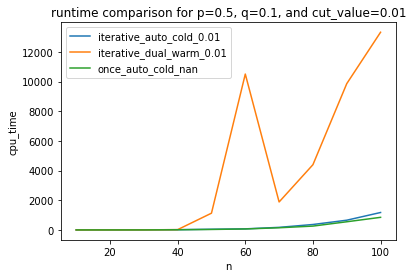

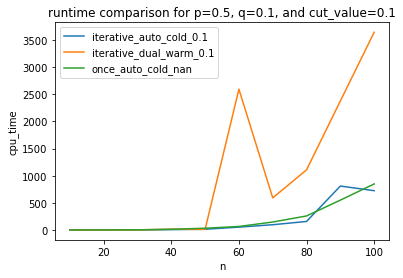

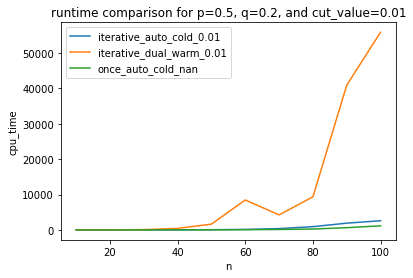

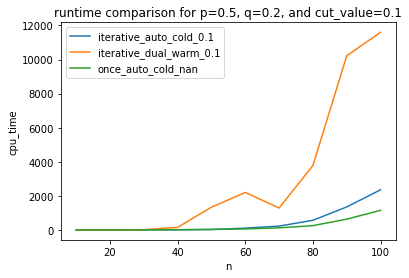

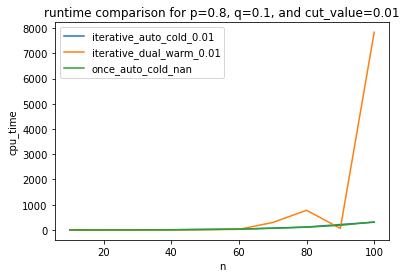

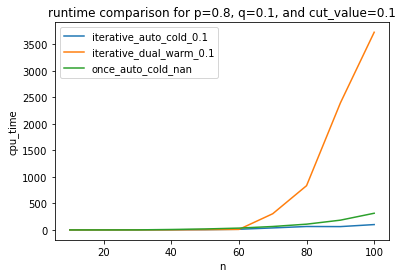

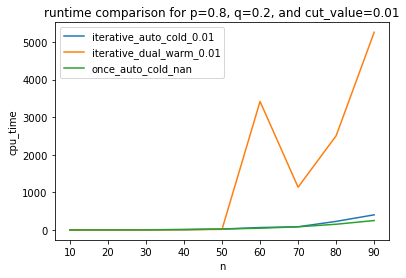

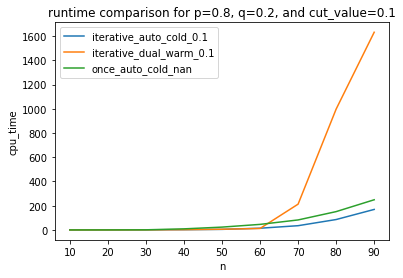

In [94]:
# new - can swap gurobi_cpu_time and total_cpu_time
time_measure = 'total_cpu_time'

# average the runs
gd = meta.groupby(['p', 'q', 'solve_type', 'method', 'warm_start', 'cut_value', 'n'])[time_measure].mean().reset_index()

# get once solves down to single data points - don't need multiple for cut_values - recasts cut_value as nan
once = gd[gd['solve_type'] == 'once']
once = once.groupby(['p', 'q', 'solve_type', 'method', 'warm_start', 'n'])[time_measure].mean().reset_index()
gd = pd.concat([gd[gd['solve_type'] != 'once'], once])
gd['idx'] = gd['solve_type'] + '_' + gd['method'] + '_' + gd['warm_start'] + '_' + gd['cut_value'].astype(str)

# filter graph data by data set
filters = {idx: gd['idx'] == idx for idx in gd['idx'].unique()}

# graph for each p, q combination 
for (p, q, cut_value) in product(gd['p'].unique(), gd['q'].unique(), gd['cut_value'].unique()):
    if pd.isnull(cut_value):
        continue
    for name, fltr in filters.items():
        # compare iterative dual warm start with once auto cold and iterative auto cold
        if name.rpartition('_')[0] not in ['once_auto_cold', 'iterative_auto_cold', 'iterative_dual_warm']:
            continue
        subset = gd.loc[(gd['p'] == p) & (gd['q'] == q) & ((gd['cut_value'] == cut_value) | (pd.isnull(gd['cut_value']))) & fltr].sort_values('n')
        if subset.shape[0] > 0:
            plt.plot(subset['n'], subset[time_measure], label=name)
        
    plt.title(f'runtime comparison for p={p}, q={q}, and cut_value={cut_value}')
    plt.ylabel('cpu_time')
    plt.xlabel('n')
    plt.legend()
    plt.show()

## Fixed Cut Adds

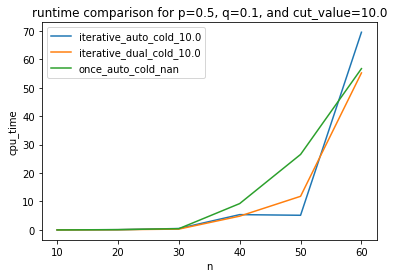

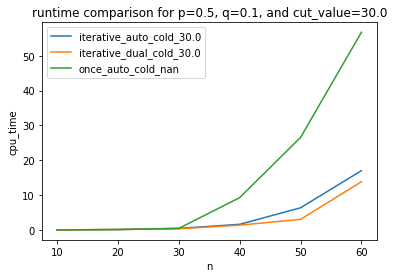

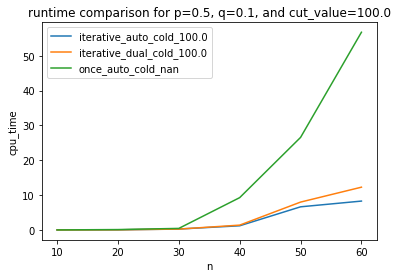

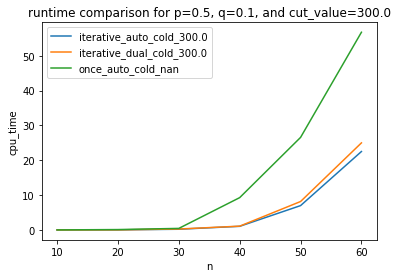

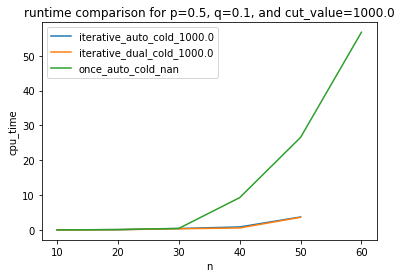

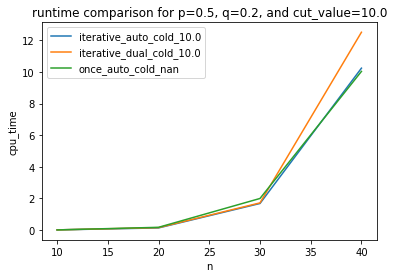

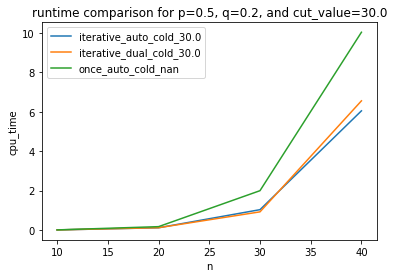

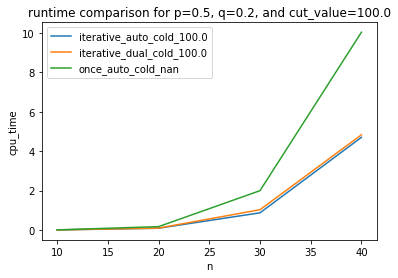

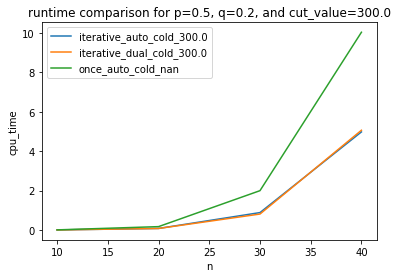

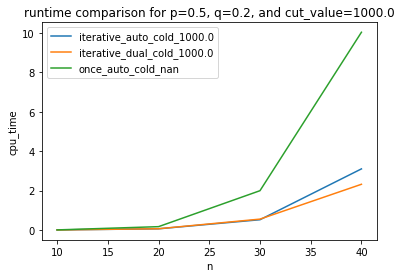

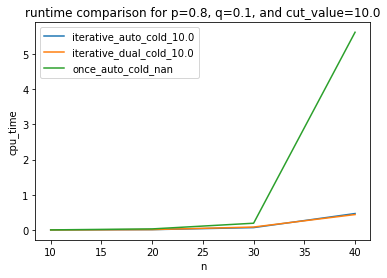

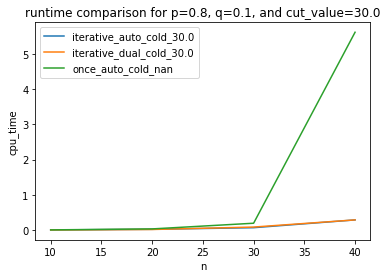

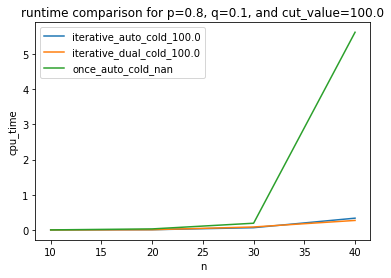

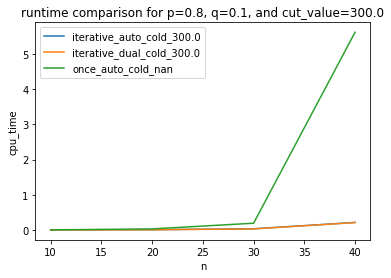

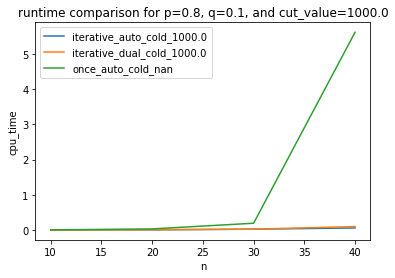

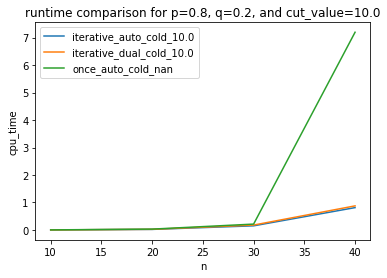

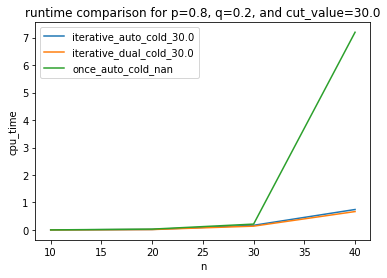

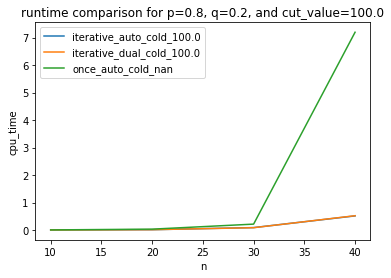

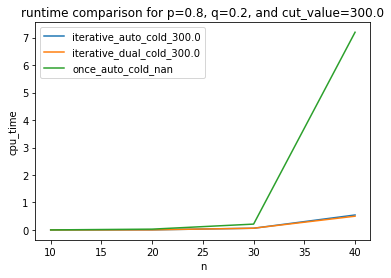

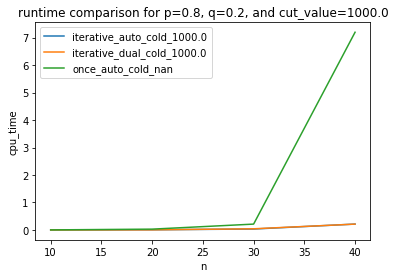

In [111]:
# new - can swap gurobi_cpu_time and total_cpu_time
time_measure = 'gurobi_cpu_time'

# average the runs
gd = meta.groupby(['p', 'q', 'solve_type', 'method', 'warm_start', 'cut_value', 'n'])[time_measure].mean().reset_index()

# get once solves down to single data points - don't need multiple for cut_values - recasts cut_value as nan
once = gd[gd['solve_type'] == 'once']
once = once.groupby(['p', 'q', 'solve_type', 'method', 'warm_start', 'n'])[time_measure].mean().reset_index()
gd = pd.concat([gd[gd['solve_type'] != 'once'], once])
gd['idx'] = gd['solve_type'] + '_' + gd['method'] + '_' + gd['warm_start'] + '_' + gd['cut_value'].astype(str)

# filter graph data by data set
filters = {idx: gd['idx'] == idx for idx in gd['idx'].unique()}

# graph for each p, q combination 
for (p, q, cut_value) in product(gd['p'].unique(), gd['q'].unique(), gd['cut_value'].unique()):
    if pd.isnull(cut_value):
        continue
    for name, fltr in filters.items():
        if 'warm' in name or 'once_dual' in name:
            continue
        subset = gd.loc[(gd['p'] == p) & (gd['q'] == q) & ((gd['cut_value'] == cut_value) | (pd.isnull(gd['cut_value']))) & fltr].sort_values('n')
        if subset.shape[0] > 0:
            plt.plot(subset['n'], subset[time_measure], label=name)
        
    plt.title(f'runtime comparison for p={p}, q={q}, and cut_value={cut_value}')
    plt.ylabel('cpu_time')
    plt.xlabel('n')
    plt.legend()
    plt.show()